In [40]:
from collections import Counter
import glob
import itertools
from itertools import izip
import os

from IPython.core.display import HTML, Image
from matplotlib import gridspec
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress
from scipy.stats import ks_2samp
import seaborn as sns

from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts import GO
from gscripts import miso

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/gp_figures"
%matplotlib inline

In [41]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/
!scp -q tscc-login.sdsc.edu:~/projects/fet_family/analysis/rna_stabality_v3/*.{metrics,final.out,txt} /nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/

In [42]:
color_map = {"fus": '#43A247',
             "FUS": '#43A247',
             'taf15': '#DB1D3D',
             'TAF15': '#DB1D3D',
             'tdp43': '#712878',
             'TDP43': '#712878',
             'fus_taf15': 'c',
             'taf15_tdp43': 'c',
             'EWS' : 'g',
             'ctrl': (0.90311419262605563, 0.54185316071790801, 0.76495195557089413)}

#colors = sns.color_palette("Set2", 4)
#rbps = ["TAF15", "FUS", "EWS", "ctrl"]
#rbp_colors = dict(zip(rbps, colors))

In [43]:
%load_ext autoreload 
%autoreload 2
reload(dataviz)
reload(GO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'gscripts.GO' from '/nas/nas0/gpratt/gscripts/gscripts/GO/__init__.pyc'>

In [44]:
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]
        
def move_name(interval):
    interval.name = interval[12]
    return interval

In [45]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

gencode_to_ensembl_dict = dict(izip(gene_id_to_name.keys(), gencode_to_ensembl(gene_id_to_name.keys())))
ensembl_to_gencode = {value: key for key, value in gencode_to_ensembl_dict.items()}


#Basic QC

In [46]:
analysis_dir = "/nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/"
fet_clip = parsers.rnaseq_metrics(analysis_dir)

filtered_guttman_clip = fet_clip[[ "Input Reads",
                            #"Reads After Triming",
                                "Percent Repetative",
                             "repetitive_count",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",

                            ]]

HTML(filtered_guttman_clip.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "repetitive_count" : parsers.commas,

                                     } ))

,Input Reads,Percent Repetative,repetitive_count,Uniquely Mapped Reads,Uniquely mapped reads %
NPC0_EWS,"10,865,722",0.3176206,"5,481,879","6,530,226",88.07%
NPC0_FUS,"7,266,698",0.7224433,"6,909,343","1,605,188",79.59%
NPC0_TAF15,"2,278,634",0.144275,"658,879","1,740,397",89.26%
NPC0_ctrl,"13,447,673",0.8153407,"14,339,146","1,846,323",74.35%
NPC15_EWS,"10,825,099",0.3080073,"5,337,511","6,609,053",88.23%
NPC15_FUS,"11,177,713",0.7902687,"11,993,356","1,780,249",75.94%
NPC15_TAF15,"5,014,992",0.1707863,"1,574,595","3,706,511",89.13%
NPC15_ctrl,"51,107,630",0.4579972,"34,451,275","23,993,075",86.62%
NPC1_EWS,"5,852,830",0.3508877,"3,254,401","3,309,627",87.12%
NPC1_FUS,"8,030,613",0.1820372,"2,737,946","5,825,812",88.69%


Conclusions
---
RNA-seq was tru-seq stranded kit with ribo-zero gold before hand to remove repetitive elements

RNA-seq is very shakey, highly different numbers of reads sequenced and repetitive elements removed.  This is partally because of ribo-seq gold treament (hopefully).  Long story short we can't use this data as a gold standard for anything, but we might be able to find targets

In [47]:
mapper = {"NPC0": 0,
"NPC15": 15,
"NPC1": 60,
"NPC30": 30,
"NPC2": 120,
"NPC4": 4 * 60}

new_index = []
for item in fet_clip.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])
    
fet_clip.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
fet_clip = fet_clip.sort_index()

In [48]:
mapped_counts = pd.Series({"NPC0_ctrl": 22.5,
"NPC0_EWS": 65.8,                   
"NPC0_FUS": 39.4,                         
"NPC0_TAF15": 64.9,                          
"NPC15_ctrl":  56.4,                        
"NPC15_EWS": 66.4,                     
"NPC15_FUS":   29.3,                          
"NPC15_TAF15": 61.3,                         
"NPC1_ctrl":  65.7,                        
"NPC1_EWS":   67.7,                         
"NPC1_FUS":  63.5,                       
"NPC1_TAF15": 61.0,
"NPC2_ctrl":  22.3,                          
"NPC2_EWS":    64.6,                          
"NPC2_FUS":  62.3,                      
"NPC2_TAF15": 56.2,                        
"NPC30_ctrl": 56.7,                        
"NPC30_EWS": 67.4,                      
"NPC30_FUS": 44.5,                        
"NPC30_FUS": 44.5,                        
"NPC30_TAF15": 66.1,                        
"NPC4_ctrl": 19.3,                        
"NPC4_EWS": 62.4,                        
"NPC4_FUS": 56.1,                    
"NPC4_TAF15": 31.2,})                

new_index = []
for item in mapped_counts.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])
    
mapped_counts.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
mapped_counts = mapped_counts.sort_index()

#Digging into Lack of Uniform Processing

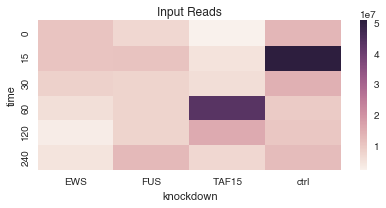

In [49]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Input Reads'].unstack().astype(float), ax=ax)
    ax.set_title("Input Reads")

Figure Legend: Heatmap of numbers of input reads, x axis is knockdown and y axis is time (in min)

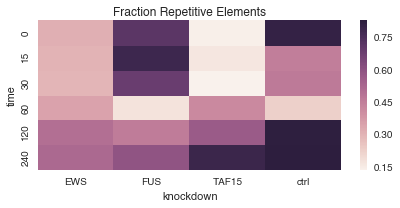

In [50]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Percent Repetative'].unstack().astype(float), ax=ax)
    ax.set_title("Fraction Repetitive Elements")

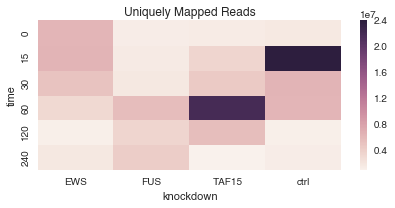

In [51]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Uniquely Mapped Reads'].unstack().astype(float), ax=ax)
    ax.set_title("Uniquely Mapped Reads")

Figure Legend: Heatmap of Fraction of repetitive elements, x axis is knockdown and y axis is time (in min)

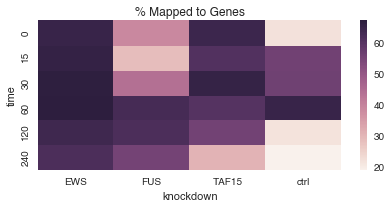

In [52]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(mapped_counts.unstack().astype(float), ax=ax)
    ax.set_title("% Mapped to Genes")

Figure Legend: Heatmap of percent of reads mapped to genes, x axis is knockdown and y axis is time (in min)

Concluiosns
---

1. Number of input reads is highly varible
2. Number of % mapped to genes is inversely correlated to % of reads removed by repetitive elements.  This is because my rmRep Script isn't perfect and small differenes will not be observed / counted.


#Check knockdowns

In [53]:
def counts_to_rpkm(featureCountsTable):
    counts = featureCountsTable.ix[:,5:]
    lengths = featureCountsTable['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)


In [54]:
#MN
stabality_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/all_counts.txt", skiprows=1, index_col=0)
stabality_counts.columns = [os.path.basename(item).split(".")[0] for item in stabality_counts.columns]
stabality_rpkm = counts_to_rpkm(stabality_counts).T

mapper = {"NPC0": 0,
"NPC15": 15,
"NPC1": 60,
"NPC30": 30,
"NPC2": 120,
"NPC4": 4 * 60}

new_index = []
for item in stabality_rpkm.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])

stabality_rpkm.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
stabality_rpkm = stabality_rpkm.sort_index()
stabality_rpkm.columns.name = "gene"

In [55]:
qc_columns = stabality_rpkm[[name_to_gene_id['TAF15'], 
                name_to_gene_id['FUS'],
                            name_to_gene_id['EWSR1']]]

qc_columns.columns = [gene_id_to_name[item] for item in qc_columns.columns]

Conclusions
---

knockdown appeared to work (for the most part), will want to check how many genes actually show global decay, relative to genes with long halflives

#Unnormalized half-lives for RPKMs, to see if time series analysis might work

RLP27, RLP13

In [56]:
stabality_rpkm_log = np.log(stabality_rpkm)

#Double check that my math is correct

In [57]:
def decay_rate(n0, t, decay_rate=.5):
    return n0 * np.exp(-1 * decay_rate * t)

def halflife_rate(n0, t, halflife=.5):
    return n0 * np.exp(halflife * t)


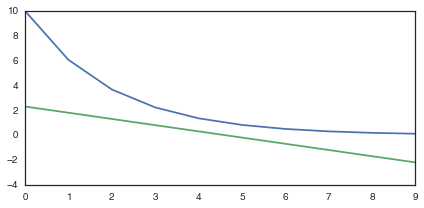

In [58]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    foo = [decay_rate(10, time) for time in np.arange(0,10)]
    ax.plot(foo)
    ax.plot(np.log(foo))

In [59]:
linregress(np.arange(0,10), np.log(foo))

LinregressResult(slope=-0.5, intercept=2.3025850929940459, rvalue=-1.0, pvalue=4.375000000000076e-80, stderr=0.0)

The halflife is .5 so I'm making a proper roundtrip, linregress / my model is correct.  

Double check my hand made results vs computed results
---

Woops deleted that check, but it works, trust me future gabe

In [60]:
def calculate_half_lives(df):
    values = ["slope", "intercept", "r-value", "p-value", "stderr"]

    results = {}
    for knockdown, df in df.groupby(level=["knockdown"]):
        df[np.isneginf(df) | np.isinf(df)] = np.nan
        df = df.dropna(axis=1)
        result = {}
        for index in df.columns:
            regression = linregress(df.index.get_level_values(level="time"), df[index])
            result[index] = dict(zip(values, regression))
        result = pd.DataFrame(result).T
        results[knockdown] = result
    half_lives = pd.concat(results, names=['knockdown', 'gene'])
    #Think about making this a bit more robust, maybe doing fitting if all contigous values are there or something
    #Calculate other stuffs
    half_lives['r2'] = half_lives['r-value']**2
    half_lives['decay'] = half_lives['slope'] * -1
    half_lives['halflife'] = half_lives.decay.apply(lambda x: np.log(2) / x)
    return half_lives

def shuffle(df, n=1, axis=0):   
    #Shuffles df by columns or rows
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df

def shuffle_stabality_df(stabality_df, axis=0):
    #shuffles multi-index by columns or rows given groupby statement
    result = {}
    for name, df in stabality_rpkm_log.groupby(level="knockdown"):
        result[name] = shuffle(df, axis=0)
    result = pd.concat(result)
    return result



In [61]:
half_lives = calculate_half_lives(stabality_rpkm_log)
shuffled_half_lives = calculate_half_lives(shuffle_stabality_df(stabality_rpkm_log))

/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Drop timepoint 0, apparently its worse...

In [62]:
trimmed_stabality_rpkm_log = stabality_rpkm_log.drop(0, level="time")

trimmed_half_lives = calculate_half_lives(trimmed_stabality_rpkm_log)
trimmed_shuffled_half_lives = calculate_half_lives(shuffle_stabality_df(trimmed_stabality_rpkm_log))


/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
trimmed_shuffled_half_lives_by_timepoint = calculate_half_lives(shuffle_stabality_df(trimmed_stabality_rpkm_log, axis=1))


/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
all_halflives = pd.concat({"half_lives": half_lives,
                           "shuffled_half_lives": shuffled_half_lives,
                           "trimmed_half_lives": trimmed_half_lives,
                           "trimmed_shuffled_half_lives": trimmed_shuffled_half_lives,
                           "trimmed_shuffled_half_lives_by_timepoint": trimmed_shuffled_half_lives_by_timepoint}, names=['exp', 'knockdown', 'gene'])

Plot Decay Rate for all samples

In [65]:
good_halflives = all_halflives[all_halflives.decay > 0]

In [66]:
all_halflives.groupby(level=['exp', 'knockdown']).count().intercept.unstack()

knockdown,EWS,FUS,TAF15,ctrl
exp,,,,
half_lives,16663,15420,15989,14189
shuffled_half_lives,16663,15420,15989,14189
trimmed_half_lives,16690,16032,16415,14674
trimmed_shuffled_half_lives,16663,15420,15989,14189
trimmed_shuffled_half_lives_by_timepoint,16663,15420,15989,14189


Check R2 for things thrown out

In [67]:
good_halflives.groupby(level=['exp', 'knockdown']).count().intercept.unstack()

knockdown,EWS,FUS,TAF15,ctrl
exp,,,,
half_lives,9023,8322,8837,8277
shuffled_half_lives,7949,7514,7755,6744
trimmed_half_lives,9128,8889,8947,8585
trimmed_shuffled_half_lives,7969,7471,7699,6830
trimmed_shuffled_half_lives_by_timepoint,8002,7537,7681,6887


#Try different scrambling methods

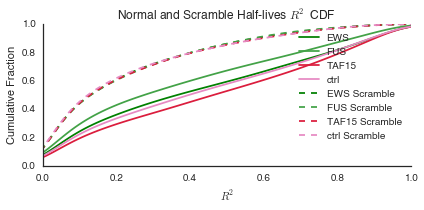

In [68]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in good_halflives.ix['half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color_map[name], ax=ax)
    
    for name, df in good_halflives.ix['shuffled_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name+ " Scramble", linestyle="--", color=color_map[name], ax=ax)
    
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_title("Normal and Scramble Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    ax.legend()

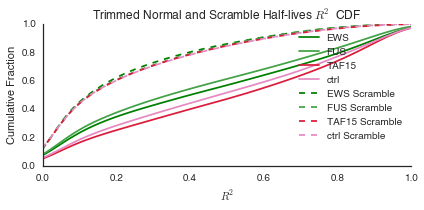

In [69]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in good_halflives.ix['trimmed_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color_map[name], ax=ax)
    
    for name, df in good_halflives.ix['trimmed_shuffled_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name + " Scramble", linestyle="--", color=color_map[name], ax=ax)
    
    ax.set_xlim(0,1)
    ax.set_title("Trimmed Normal and Scramble Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    sns.despine(ax=ax)
    ax.legend()

In [88]:
sns.__version__

'0.6.0'

In [70]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/gp_figures'

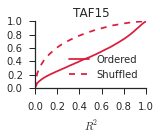

In [91]:
with dataviz.Figure(os.path.join(img_dir, "taf15_halflife_validation.svg"), figsize=(num_cols * 2, num_rows * 2.0)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,2)
    dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'TAF15'].r2, label="Ordered", color=color_map['TAF15'], ax=ax)
    dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'TAF15'].r2, label="Shuffled", linestyle="--", color=color_map['TAF15'], ax=ax)
    ax.set_xlim(0,1)
    ax.set_title("TAF15")
    ax.set_xlabel("$R^2$")
    #ax.set_ylabel("Cumulative Fraction")
    #ax.set_yticks([])
    sns.despine(ax=ax)
    ax.legend(loc=0)

In [103]:
print np.median(good_halflives.ix['trimmed_half_lives', 'TAF15'].r2), np.median(good_halflives.ix['trimmed_shuffled_half_lives', 'TAF15'].r2)

0.540203012239 0.12412484395


In [94]:
#KS test
scipy.stats.ks_2samp(good_halflives.ix['trimmed_half_lives', 'TAF15'].r2, good_halflives.ix['trimmed_shuffled_half_lives', 'TAF15'].r2)

Ks_2sampResult(statistic=0.38909603657671299, pvalue=0.0)

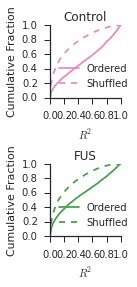

In [111]:
num_rows = 2
num_cols = 1
#with sns.set_style("ticks"):
with dataviz.Figure(os.path.join(img_dir, "halflife_validation.svg"), figsize=(num_cols * 2, num_rows * 2.0)) as fig:
    
    ax = fig.add_subplot(num_rows,num_cols,1)
    dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'ctrl'].r2, label="Ordered", color=color_map['ctrl'], ax=ax)
    dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'ctrl'].r2, label="Shuffled", linestyle="--", color=color_map['ctrl'], ax=ax)
    ax.set_xlim(0,1)
    ax.set_title("Control")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    sns.despine(ax=ax)
    ax.legend(loc=0)

    ax = fig.add_subplot(num_rows,num_cols,2)
    dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'FUS'].r2, label="Ordered", color=color_map['FUS'], ax=ax)
    dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'FUS'].r2, label="Shuffled", linestyle="--", color=color_map['FUS'], ax=ax)
    ax.set_xlim(0,1)
    ax.set_title("FUS")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    #ax.set_yticks([])
    sns.despine(ax=ax)
    ax.legend(loc=0)

#     ax = fig.add_subplot(num_rows,num_cols,4)
#     dataviz.plot_cdf(good_halflives.ix['trimmed_half_lives', 'EWS'].r2, label="Ordered", color=color_map['EWS'], ax=ax)
#     dataviz.plot_cdf(good_halflives.ix['trimmed_shuffled_half_lives', 'EWS'].r2, label="Shuffled", linestyle="--", color=color_map['EWS'], ax=ax)
#     ax.set_xlim(0,1)
#     ax.set_title("EWS")
#     ax.set_xlabel("$R^2$")
#     ax.set_ylabel("Cumulative Fraction")
#     sns.despine(ax=ax)
#     ax.legend(loc=0)



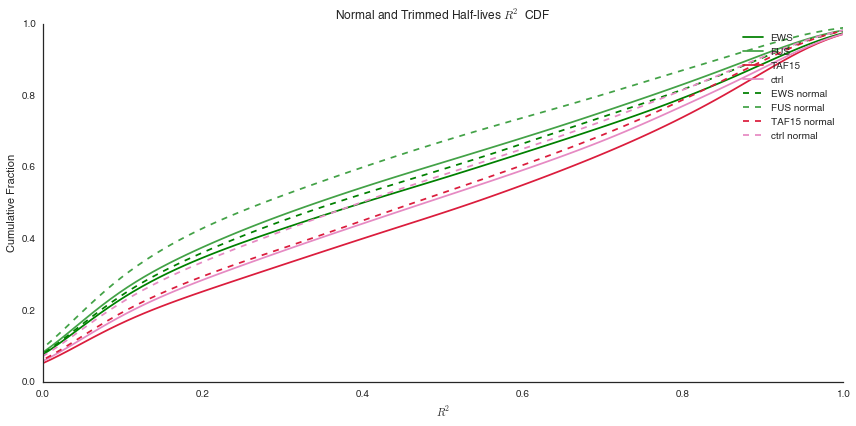

In [72]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(12,6)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in good_halflives.ix['trimmed_half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color_map[name], ax=ax)
    
    for name, df  in good_halflives.ix['half_lives'].groupby(level="knockdown"):
        sns.kdeplot(df.r2, cumulative=True, label=name + " normal", linestyle="--", color=color_map[name], ax=ax)
    
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_title("Normal and Trimmed Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    ax.legend()

#Method:
The equation I'm trying to fit is N(t) = $N_0e^{-\lambda t}$
If you take the ln of each side

ln(N(t)) = $ln(N_0) + -\lambda t$

You can fit this via linear regression, where slope = $-\lambda$

For scramble control I scrambled time points for the same gene.

#Conclusions
1. Scramble has somewhat uniform error, and is always worse than normal, which is good
2. If you trim off $T_0$ you get strictly better results from fitting the linear regression.  Could this be because you've just got fewer datapoints to fit?

#Final Dataset Choices
Because trimming is better I'm just going to use that dataset for the rest of the analysis
Really don't know if trimming is better, need to hit on it a bit more

All trimmed half-lives where we have high confidence values for control and the thing of interest

In [73]:
well_correlated_halflives = good_halflives[good_halflives.r2 > .6]
high_confidence_halflives = well_correlated_halflives.ix['trimmed_half_lives']
high_confidence_halflives = high_confidence_halflives.halflife.unstack()

#Descriptive Stats

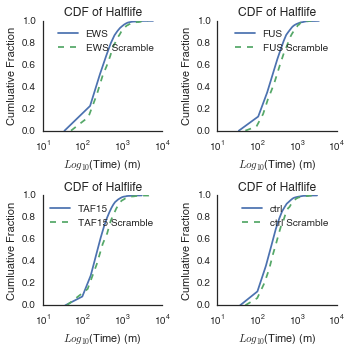

In [74]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    for x, (name, df) in enumerate(well_correlated_halflives.groupby(level="knockdown")):
        ax = fig.add_subplot(2,2,x+1)
        
        dataviz.plot_cdf(df.ix['trimmed_half_lives'].halflife,
                         label=name, 
                         #color=colors[x], 
                         ax=ax)
        dataviz.plot_cdf(df.ix['trimmed_shuffled_half_lives'].halflife, 
                         label=name + " Scramble", 
                         linestyle="--", 
                         #color=color, 
                         ax=ax)

        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (m)")
        ax.set_xscale("log", basex=10)
        ax.legend()
        sns.despine(ax=ax)

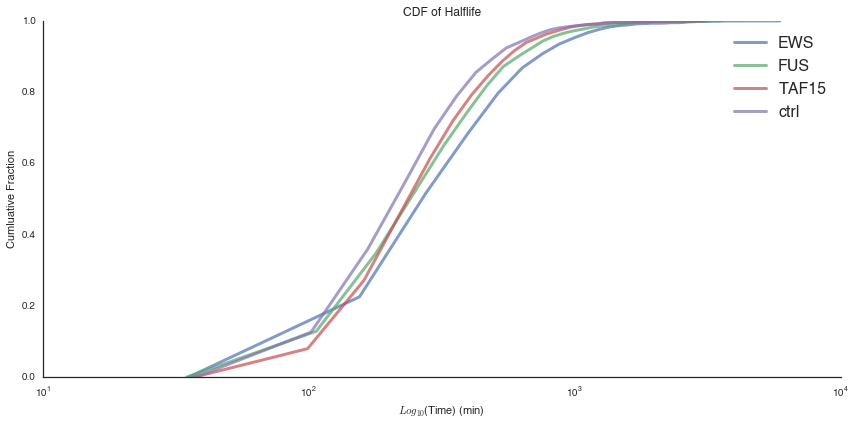

In [75]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(12,6)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    #add in scrambles
    #log time scale
    for name, df in high_confidence_halflives.groupby(level="knockdown"):
            dataviz.plot_cdf(df.irow(0).dropna(), label=name, ax=ax, alpha=.7, linewidth=3)
    ax.legend(loc=0, fontsize=16)
    #ax.set_xlim(0, 2000)
    ax.set_title("CDF of Halflife")
    ax.set_ylabel("Cumluative Fraction")
    ax.set_xlabel("$Log_{10}$(Time) (min)")
    ax.set_xscale("log", basex=10)
    sns.despine(ax=ax)

In [77]:
import statsmodels as sm

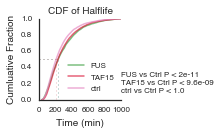

In [79]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "taf15_halflife_cdf.svg"), figsize=(2.0 * num_cols, 2.0 * num_rows)) as fig:
    grouped_halflives = high_confidence_halflives[high_confidence_halflives < 1000].groupby(level="knockdown")

    for x, (name, df) in enumerate(grouped_halflives):
        if not ((name == "TAF15") or (name == "FUS") or (name == "ctrl")):
            continue
        ax = fig.add_subplot(num_rows,num_cols, 1)
        kd = df.irow(0).dropna()
        ctrl = grouped_halflives.get_group("ctrl").irow(0).dropna()
        cdf = sm.distributions.ECDF(kd) 
        index = np.where((cdf.y > .499) & (cdf.y < .500001))[0][0]
        y_mid = cdf.y[index]
        x_mid = cdf.x[index]
        dataviz.plot_cdf(kd, 
                         label=name, 
                         ax=ax, 
                         alpha=.7,
                         color=color_map[name], 
                         linewidth=1.5)
        
        ax.plot([0, x_mid, x_mid], [y_mid, y_mid, 0], linewidth=.5, alpha=.7, linestyle=":")
        d, p_value = ks_2samp(kd, ctrl)
        ax.legend(loc=0, fontsize=8)
        ax.set_title("CDF of Halflife", fontsize=10)
        ax.set_ylabel("Cumluative Fraction", fontsize=10)
        ax.set_xlabel("Time (min)", fontsize=10)
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1)
        ax.text(1, .4 - (x / 10.0), "{} vs Ctrl P < {:.2}".format(name, p_value), 
               transform=ax.transAxes, fontsize=8)
        
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
        sns.despine(ax=ax)

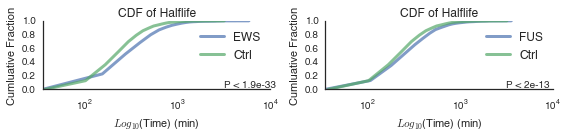

In [80]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "other_halflife_cdf.svg"), figsize=(4.0 * num_cols, 2.0 * num_rows)) as fig:
    grouped_halflives = high_confidence_halflives.groupby(level="knockdown")
    #add in scrambles
    #log time scale
    for x, (name, df) in enumerate(grouped_halflives):
        if name == "ctrl" or name == "TAF15":
            continue
        ax = fig.add_subplot(num_rows,num_cols, x+1)
        kd = df.irow(0).dropna()
        ctrl = grouped_halflives.get_group("ctrl").irow(0).dropna()
        dataviz.plot_cdf(kd, label=name, ax=ax, alpha=.7, linewidth=3)
        dataviz.plot_cdf(ctrl, label="Ctrl", ax=ax, alpha=.7, linewidth=3)
        d, p_value = ks_2samp(kd, ctrl)
        ax.legend(loc=0, fontsize=12)
        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (min)")
        ax.set_xscale("log", basex=10)
        ax.set_xlim(0, pow(10,4))

        ax.text(pow(10,3.5), .05, "P < {:.2}".format(p_value))
        sns.despine(ax=ax)

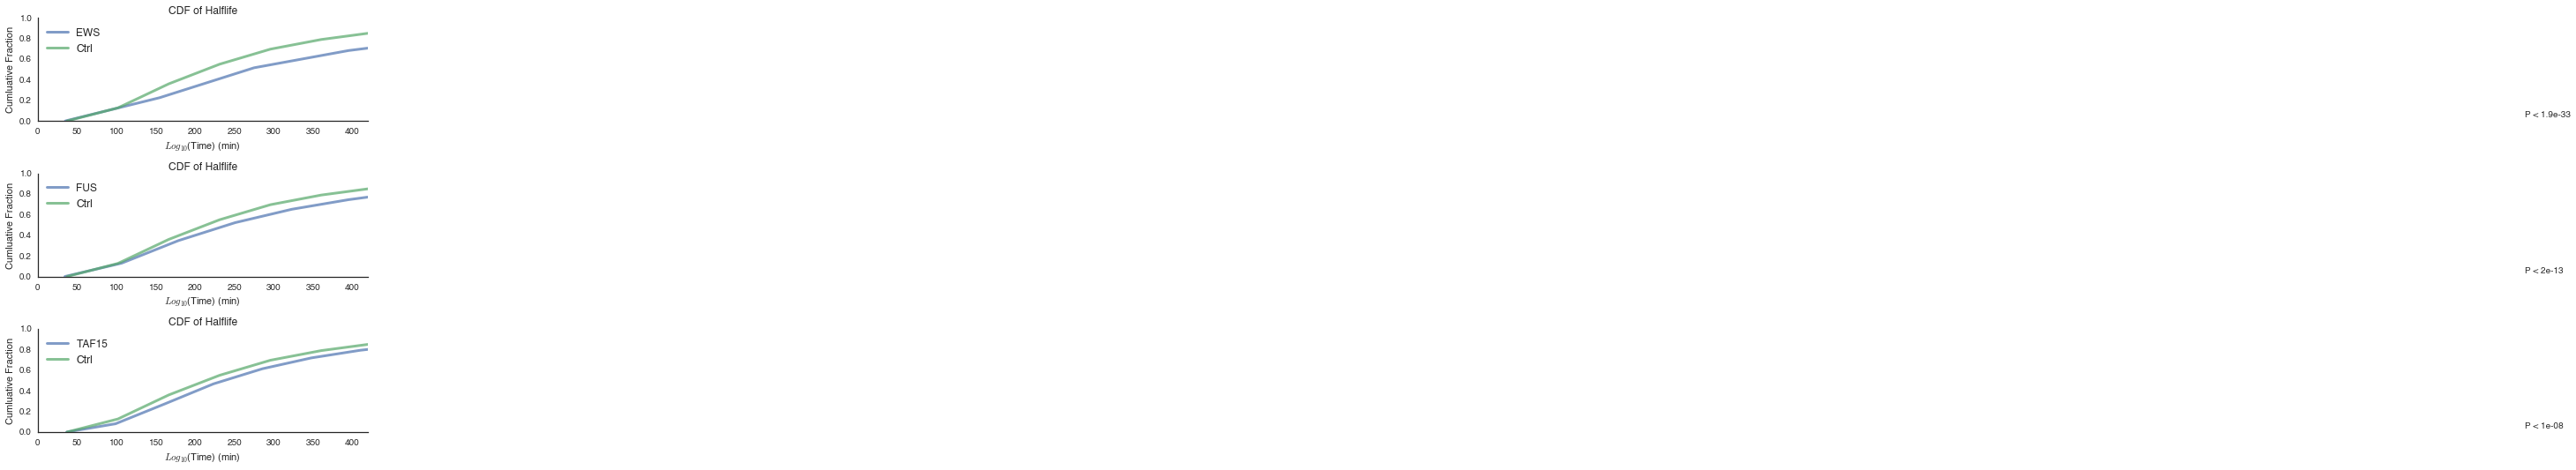

In [81]:
num_rows = 3
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6.0 * num_cols, 2.5 * num_rows)) as fig:
    grouped_halflives = high_confidence_halflives.groupby(level="knockdown")
    #add in scrambles
    #log time scale
    for x, (name, df) in enumerate(grouped_halflives):
        if name == "ctrl":
            continue
        ax = fig.add_subplot(num_rows,num_cols, x+1)
        kd = df.irow(0).dropna()
        ctrl = grouped_halflives.get_group("ctrl").irow(0).dropna()
        dataviz.plot_cdf(kd, label=name, ax=ax, alpha=.7, linewidth=3)
        dataviz.plot_cdf(ctrl, label="Ctrl", ax=ax, alpha=.7, linewidth=3)
        d, p_value = ks_2samp(kd, ctrl)
        ax.legend(loc=0, fontsize=12)
        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (min)")
        #ax.set_xscale("log", basex=10)
        ax.set_xlim(0, 420)

        ax.text(pow(10,3.5), .05, "P < {:.2}".format(p_value))
        sns.despine(ax=ax)

Something is wrong with my calculations... I get much longer $\lambda$ than kasey

Figure Legend: Overall distributions of halflife for each RBP and the control.  Split out into three comparisons for easier visualization and comparison

#Conclusions
1. TAF15, FUS and EWS all appear to have somewhat of a stabalizing effect when knocked down.  

#Identify RNAs with large $\Delta$ half-life


In [82]:
delta_halflife_prep = high_confidence_halflives[high_confidence_halflives.ix['ctrl'].dropna().index]
delta_halflife = delta_halflife_prep - delta_halflife_prep.ix['ctrl']

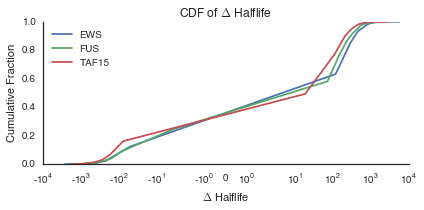

In [83]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
        if name == "ctrl":
            continue
        dataviz.plot_cdf(df.irow(0).dropna(), label=name, ax=ax)
    ax.legend(loc=0)
    #ax.set_xlim(-500, 500)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$\Delta$ Halflife")
    ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

In [84]:
high_confidence_halflives

gene,ENSG00000000457.8,ENSG00000000460.12,ENSG00000001036.8,ENSG00000001084.6,ENSG00000001167.10,ENSG00000001629.5,ENSG00000002016.11,ENSG00000002587.5,ENSG00000002919.10,ENSG00000003096.9,...,ENSG00000271662.1,ENSG00000271707.1,ENSGR0000167393.12,ENSGR0000169084.8,ENSGR0000169093.10,ENSGR0000182484.10,ENSGR0000197976.6,ENSGR0000214717.4,ENSGR0000223773.2,ENSGR0000237801.1
knockdown,,,,,,,,,,,,,,,,,,,,,
EWS,NaN,NaN,922.603838,492.531912,407.688416,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,563.263994,NaN,409.241647,NaN,NaN,80.72641
FUS,211.308572,778.998015,NaN,208.436150,227.186733,1524.395936,349.928648,110.871814,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,204.939245,191.803648,402.127316,NaN,NaN
TAF15,80.968739,NaN,NaN,NaN,NaN,NaN,139.814369,NaN,203.469173,233.312464,...,388.529544,NaN,331.611834,NaN,NaN,NaN,294.001854,153.324804,235.148293,NaN
ctrl,NaN,NaN,NaN,NaN,NaN,228.568338,NaN,NaN,92.224724,NaN,...,NaN,198.872531,NaN,134.080589,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
high_confidence_halflives[name_to_gene_id['NUP37']]

knockdown
EWS              NaN
FUS              NaN
TAF15     235.046628
ctrl     1714.916832
Name: ENSG00000075188.4, dtype: float64

In [86]:
high_confidence_halflives.xs(name_to_gene_id['NUP37'], level="gene")

AttributeError: 'Index' object has no attribute 'get_loc_level'

In [ ]:
ctrl_destabalized

In [ ]:
delta_halflife_prep = high_confidence_halflives[high_confidence`_halflives.ix['ctrl'].dropna().index]
delta_halflife = np.log2(delta_halflife_prep / delta_halflife_prep.ix['ctrl'])

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
        if name == "ctrl":
            continue
        dataviz.plot_cdf(df.irow(0).dropna(), label=name, color=color_map[name], ax=ax)
    ax.legend(loc=0)
    ax.set_xlim(-4, 4)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$log2_{(rbp/ctrl)}$ Halflife")
    ax.axhline(.5)
    ax.axvline(0)
    #ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "taf15_delta_halflife.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
        if name != "TAF15":
            continue
        dataviz.plot_cdf(df.irow(0).dropna(), label=name, color=color_map[name], ax=ax)
    ax.legend(loc=0)
    #ax.set_xlim(-500, 500)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$\Delta$ Halflife (min)")
    ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

#Plot comparisons of delta halflife between taf15 and FUS

In [ ]:
fus = delta_halflife.ix[['TAF15', 'FUS']].dropna(axis=1).ix['FUS']
taf15 = delta_halflife.ix[['TAF15', 'FUS']].dropna(axis=1).ix['TAF15']

In [ ]:
foo = np.log10(high_confidence_halflives.ix[['TAF15', 'FUS', 'ctrl']].dropna(axis=1))

In [ ]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(foo.ix['TAF15'], foo.ix['FUS'], s=.5, alpha=.7)
    print linregress(foo.ix['TAF15'], foo.ix['FUS'])
    sns.despine(ax=ax)
    ax.set_title("Halflife between TAF15 and FUS")
    ax.set_ylabel("TAF15 Halflife")
    ax.set_xlabel("FUS Halflife")

In [ ]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(foo.ix['TAF15'], foo.ix['ctrl'], s=.5, alpha=.7)
    print linregress(foo.ix['TAF15'], foo.ix['ctrl'])
    sns.despine(ax=ax)
    ax.set_title("Halflife between ctrl and TAF15")
    ax.set_ylabel("TAF15 Halflife")
    ax.set_xlabel("ctrl Halflife")

In [ ]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(foo.ix['ctrl'], foo.ix['FUS'], s=.5, alpha=.7)
    print linregress(foo.ix['ctrl'], foo.ix['FUS'])
    sns.despine(ax=ax)
    ax.set_title("Halflife between ctrl and FUS")
    ax.set_ylabel("ctrl Halflife")
    ax.set_xlabel("FUS Halflife")

In [ ]:
num_rows = 5
num_cols = 5
with dataviz.Figure(os.path.join(img_dir, "destabalization_correlation.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(fus, taf15, s=.5, alpha=.7)
    print linregress(fus, taf15)
    sns.despine(ax=ax)
    ax.set_title("$\Delta$ Stabality between FUS and TAF15")
    ax.set_ylabel("TAF15 $\Delta$ Stabality")
    ax.set_xlabel("FUS $\Delta$ Stabality")

In [ ]:
taf15_delta_genes = delta_halflife.ix['TAF15'].dropna()
taf15_delta_genes.sort()

In [ ]:
taf15_stabalized_df = pd.concat({"Stabalized": taf15_delta_genes[taf15_delta_genes > 0],
                                 "Destabalized": taf15_delta_genes[taf15_delta_genes < 0]}, names=['type'])

In [ ]:
taf15_stabalized_df.groupby(level="type").count()

#Add to the plot if the genes are bound in mouse

In [ ]:
from clipper.src import CLIP_analysis

In [ ]:
regions, all_regions = CLIP_analysis.regions_generator()

In [ ]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

binding_df = []
assigned_peaks = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    cluster_regions = CLIP_analysis.assign_to_regions(overlapping_genes, name, 
                                    regions, "assigned", nrand=3, species="mm9")
    assigned_peaks[name] = cluster_regions
    for region in cluster_regions.keys():
        gene_names = pd.Series(Counter([interval.name.split(",")[0] for interval in cluster_regions[region]['real']]),
                                name=name + "_" + region)
        gene_names.name = (name, region)
        binding_df.append(gene_names)
binding_df = pd.concat(binding_df,axis=1)
binding_df.columns = pd.MultiIndex.from_tuples(binding_df.columns)
binding_df = binding_df.T
binding_df = binding_df.stack()
binding_df.index.names = ['rbp', 'region', 'gene_id']
binding_df = binding_df.sort_index()

In [ ]:
mouse_gene_id_names = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/mouse_gene_id_to_names.txt", index_col=0)
human_mouse_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=2)
mouse_human_genes = human_mouse_genes
mouse_human_genes['gene_id'] = mouse_human_genes.index
mouse_human_genes.index = mouse_human_genes['Ensembl Gene ID']
mouse_human_genes_dict = dict(izip(mouse_human_genes.index, mouse_human_genes.gene_id))

In [ ]:
new_index = []
for rbp, region, gene_id in binding_df.index:
    try:
        gene_id  = mouse_human_genes_dict[gene_id.split(".")[0]]
    except KeyError:
        gene_id = "error"
    new_index.append([rbp, region, gene_id])
binding_df.index = pd.MultiIndex.from_tuples(new_index)

#Plot Stabality Experiments

In [ ]:
grouped_kd_rpkms = stabality_rpkm.groupby(level="knockdown")

In [ ]:
def format_df(df):
    """ formats df for plotting in heatmap very specific helper function"""
    df.index = df.index.get_level_values(level=0)
    df.columns = [gene_id_to_name[gene_id] for gene_id in df.columns]
    return df

def get_halflives(df, rbp):
    halflives = trimmed_half_lives.swaplevel(0,1).ix[df.columns].xs(rbp, level=1)
    halflives.halflife[(halflives.r2 < .6) | (halflives.halflife < 0)] = np.nan
    halflives.index = [gene_id_to_name[gene_id] for gene_id in halflives.index]
    return halflives.halflife

In [ ]:
rip_targets = """CGGBP1
TCERG1
PRKRIR
SENP2
RAPGEF1
ATXN7L3B
NUFIP1
URB1
CLN8""".split("\n")
rip_gene_targets = [name_to_gene_id[gene_name] for gene_name in rip_targets]

In [ ]:
number_changing = 10
destabalized_gene_list = taf15_stabalized_df.ix['Destabalized'][:number_changing].index | taf15_stabalized_df.ix['Destabalized'][rip_gene_targets].dropna().index 

taf15_destabalized = grouped_kd_rpkms.get_group("TAF15")[destabalized_gene_list]
fus_destabalized = grouped_kd_rpkms.get_group("FUS")[destabalized_gene_list]
ctrl_destabalized = grouped_kd_rpkms.get_group("ctrl")[destabalized_gene_list]

taf15_destabalized_bound_in_mouse_brain = binding_df.ix['taf15', 'all'][[gene_id.split(".")[0] for gene_id in taf15_destabalized]]
fus_destabalized_bound_in_mouse_brain = binding_df.ix['fus', 'all'][[gene_id.split(".")[0] for gene_id in fus_destabalized]]

taf15_destabalized_hl = get_halflives(taf15_destabalized, "TAF15")
fus_destabalized_hl = get_halflives(fus_destabalized, "FUS")
ctrl_destabalized_hl = get_halflives(ctrl_destabalized, "ctrl")

taf15_destabalized = format_df(taf15_destabalized)
fus_destabalized = format_df(fus_destabalized)
ctrl_destabalized = format_df(ctrl_destabalized)

number_changing = number_changing * -1
stabalized_gene_list = taf15_stabalized_df.ix['Stabalized'][number_changing:].index | taf15_stabalized_df.ix['Stabalized'][rip_gene_targets].dropna().index

taf15_stabalized = grouped_kd_rpkms.get_group("TAF15")[stabalized_gene_list]
fus_stabalized = grouped_kd_rpkms.get_group("FUS")[stabalized_gene_list]
ctrl_stabalized = grouped_kd_rpkms.get_group("ctrl")[stabalized_gene_list]

taf15_stabalized_bound_in_mouse_brain = binding_df.ix['taf15', 'all'][[gene_id.split(".")[0] for gene_id in taf15_stabalized]]
fus_stabalized_bound_in_mouse_brain = binding_df.ix['fus', 'all'][[gene_id.split(".")[0] for gene_id in fus_stabalized]]

taf15_stabalized_hl = get_halflives(taf15_stabalized, "TAF15")
fus_stabalized_hl = get_halflives(fus_stabalized, "FUS")
ctrl_stabalized_hl = get_halflives(ctrl_stabalized, "ctrl")

taf15_stabalized = format_df(taf15_stabalized)
fus_stabalized = format_df(fus_stabalized)
ctrl_stabalized = format_df(ctrl_stabalized)

In [ ]:
def plot_heatmap(df, halflives, ax, cbar=False, cbar_ax=None):
    internally_normalized = df.T
    internally_normalized = internally_normalized.div(internally_normalized[0], axis=0)

    sns.heatmap(np.log2(internally_normalized), 
                linewidths=.1, 
                vmax=vmax,
                vmin=vmin,
                cmap=cmap,
                cbar=cbar,
                cbar_ax=cbar_ax,
                linecolor='k',
                ax=ax)
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    
    ypos = ax.get_yticks()
    xpos = ax.get_xticks()
    halflife_xpos = (xpos[-1] - xpos[-2]) + xpos[-1] 

    
#     for y, halflife in zip(ypos, halflives):
#         if np.isnan(halflife):
#             halflife = "NA"
#             ax.text(halflife_xpos, y, "N/A", ha="left", va="center", fontsize=8)
#         else:
#             ax.text(halflife_xpos, y, "{:,.1f}".format(halflife),
#                     ha="left", va="center", fontsize=8)
        
#     halflife_ypos = ypos[-1] + (ypos[-1] - ypos[-2])
#     ax.text(halflife_xpos, halflife_ypos, "$T_{1/2}$ (min)", ha="left", va="center", fontsize=8)
        
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    [tick.set_fontsize(7) for tick in ax.get_xticklabels()]
    
def plot_bound(df, ax=ax):
    df = df.fillna(0)
    df[df >= 1] = 1
    sns.heatmap(pd.DataFrame(df), 
                cbar=False, 
                xticklabels=False, 
                yticklabels=False,
               linecolor='k')

In [ ]:
taf15_bound = { "CGGBP1":, 
"TCERG1":,
"PRKRIR": ,
"SENP2":,
"RAPGEF1":,
"ATXN7L3B":,
"NUFIP1":,
"URB1":,
"CLN8":,
             
fus_bound = { "CGGBP1":, 
"TCERG1":,
"PRKRIR": ,
"SENP2":,
"RAPGEF1":,
"ATXN7L3B":,
"NUFIP1":,
"URB1":,
"CLN8":,

In [ ]:
taf15_stabalized_bound_in_mouse_brain

In [ ]:
taf15_stabalized_bound_in_mouse_brain.index = [ensembl_id_to_name[name] for name in taf15_stabalized_bound_in_mouse_brain.index]

In [ ]:
taf15_stabalized_bound_in_mouse_brain

In [ ]:
taf15_stabalized

In [ ]:
img_dir

In [ ]:
num_rows = 2
num_cols = 18
gs = gridspec.GridSpec(num_rows, num_cols)
vmin = -1.0
vmax = 1.0
cmap = "RdBu"
with dataviz.Figure(os.path.join(img_dir, "stabality_heatmap.svg"), figsize=(6,4)) as fig:
    ax = fig.add_subplot(gs[0,0:5])
    
    plot_heatmap(ctrl_stabalized, reversed(ctrl_stabalized_hl), ax=ax)
    ax.set_title("Control", fontsize=10)
    ax.set_ylabel("Stabalized", fontsize=10)
    ax.set_xlabel("")
    ax.set_xticklabels([])

    ax = fig.add_subplot(gs[0,5:10])
    plot_heatmap(taf15_stabalized, reversed(taf15_stabalized_hl), ax=ax)
    ax.set_yticklabels([])
    ax.set_title("TAF15 Knockdown", fontsize=6)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[0,10])
    plot_bound(taf15_stabalized_bound_in_mouse_brain, ax)
    #ax.set_title("Bound", fontsize=6)
    
    ax = fig.add_subplot(gs[0,11:16])
    cbar_ax = fig.add_subplot(gs[0,17])

    plot_heatmap(fus_stabalized, reversed(fus_stabalized_hl), ax=ax, cbar=True, cbar_ax=cbar_ax)
    ax.set_yticklabels([])
    ax.set_title("FUS Knockdown", fontsize=8)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[0,16])
    plot_bound(fus_stabalized_bound_in_mouse_brain, ax)
    #ax.set_title("Bound", fontsize=8)

    ax = fig.add_subplot(gs[1,0:5])
    plot_heatmap(ctrl_destabalized, reversed(ctrl_destabalized_hl), ax=ax)
    ax.set_ylabel("Destabilized", fontsize=10)
    ax.set_xlabel("Time (min)", fontsize=8)

    ax = fig.add_subplot(gs[1,5:10])
    plot_heatmap(taf15_destabalized,reversed(taf15_destabalized_hl), ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel("Time (min)", fontsize=8)

    ax = fig.add_subplot(gs[1,10])
    plot_bound(taf15_destabalized_bound_in_mouse_brain, ax)
    
    ax = fig.add_subplot(gs[1,11:16])
    plot_heatmap(fus_destabalized, reversed(fus_destabalized_hl), ax=ax)
    ax.set_yticklabels([])
    ax.set_xlabel("Time (min)", fontsize=8)
    
    ax = fig.add_subplot(gs[1,16])
    plot_bound(fus_destabalized_bound_in_mouse_brain, ax)

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 1) + 1 
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "top_40_destabalized_genes.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Destabalized'][:num_genes].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15']
        )
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])
        
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

Figure Legend: Top 40 most destabalized TAF15 Genes

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 1
num_rows = (num_genes / 1) + 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "best_stabalized_gene.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][-1 * num_genes:].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
               color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])  
        
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 1) + 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "top_40_stabalized_genes.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][-1 * num_genes:].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
               color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])  
        
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

Figure Legend: Top 40 Most stabalized TAF15 Genes

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 1) + 1
num_cols = 1
count = 0
with dataviz.Figure(os.path.join(img_dir, "no_change_group.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][:num_genes / 2].index):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])
        
        ax.set_title(gene_id_to_name[gene])
        
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))
        
    for x, gene in enumerate(taf15_stabalized_df.ix['Destabalized'][-1 * (num_genes / 2):].index):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
               color=color_map['TAF15'])
        
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])     
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))

Figure Legend: Top 40 least changing genes, first 20 are the least $\Delta$ increase in stabality. Second 20 are the least $\Delta$ decrease in stabality

#Plot Genes that we are just going to show in the paper

In [ ]:
def plot_individual_gene(gene_name, ax):
        gene = name_to_gene_id[gene_name]

        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        fus = grouped_kd_rpkms.get_group("FUS")[gene]

        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.plot(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15'])

        halflife = trimmed_half_lives.ix['FUS', gene].halflife
        r2 = trimmed_half_lives.ix['FUS', gene].r2
        ax.plot(fus.index.get_level_values(level="time"), 
                fus.values, 
                label="FUS KD $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['FUS'])

        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.plot(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'])

        ax.set_title(gene_id_to_name[gene], fontsize=12)

        ax.set_xlabel("Time (m)", fontsize=8)
        ax.set_ylabel("RPKM", fontsize=8)
        sns.despine(ax=ax)
        [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
        ax.legend(loc=2, fontsize=8, bbox_to_anchor=(1.0, 1))

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 1
num_rows = 1
num_cols = 1

with dataviz.Figure(os.path.join(img_dir, "CGGBP1.svg"), figsize=(num_cols * 1.8,num_rows * 1.8)) as fig:
        ax = fig.add_subplot(num_rows,num_cols, count)
        plot_individual_gene('CGGBP1', ax)

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "CLN8.svg"), figsize=(num_cols * 1.8,num_rows * 1.8)) as fig:
        ax = fig.add_subplot(num_rows,num_cols, count)
        plot_individual_gene('CLN8', ax)

#Do GO Analysis, look for ALS related genes that have $\Delta$ stabality

In [ ]:
hg19go = GO.hg19GO()

In [ ]:
result = {}
for name, df in taf15_stabalized_df.groupby(level="type"):
    background = gencode_to_ensembl(stabality_rpkm.ix[0, 'ctrl'][stabality_rpkm.ix[0, 'ctrl'] > 2].index)
    result[name] = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene")),
                                    background=background)

go_results = pd.concat(result, names=['stabality', 'go_term_id'])
go_results = go_results[go_results['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [ ]:
HTML(go_results.to_html())

In [ ]:
#TAF15 Might change histone RNA stabality? Is that interesting?

In [ ]:
dataviz.plot_go_enrichment(go_results, figsize=(5,30))

#Validate RPKMs from Kasey's results

In [ ]:
kasey_results = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/Half_life_analysis_khutt.xls", "Data", index_col=0)

Could look to see if the motif we define is enriched in stabalized vs destablized or unchanging elements...

#Looking at LIF

In [ ]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 1
num_rows = (num_genes / 1) + 1
num_cols = 1
count = 0
with dataviz.Figure(os.path.join(img_dir, "lif_stabality.svg"), figsize=(num_cols * 2.0,num_rows * 2.0)) as fig:
    for x, gene in enumerate([name_to_gene_id['LIF']]):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = grouped_kd_rpkms.get_group("TAF15")[gene]
        ctrl = grouped_kd_rpkms.get_group("ctrl")[gene]
        halflife = trimmed_half_lives.ix['TAF15', gene].halflife
        r2 = trimmed_half_lives.ix['TAF15', gene].r2
        ax.scatter(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="TAF15 KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['TAF15'],
                  alpha=.7)
        
        ax.plot(kd.index.get_level_values(level="time"), 
                decay_rate(kd.values[0], kd.index.get_level_values(level="time"), trimmed_half_lives.ix['TAF15', gene].decay),
                color=color_map['TAF15'],
               alpha=.7)        
        
        kd = grouped_kd_rpkms.get_group("FUS")[gene]
        halflife = trimmed_half_lives.ix['FUS', gene].halflife
        r2 = trimmed_half_lives.ix['FUS', gene].r2
        ax.scatter(kd.index.get_level_values(level="time"), 
                kd.values, 
                label="FUS KD $T_{{1/2}}$ = {:.2f}(min), $R^2$ = {:.2}".format(halflife, r2),
                color=color_map['FUS'],
                  alpha=.7)
        
        ax.plot(kd.index.get_level_values(level="time"), 
                decay_rate(kd.values[0], kd.index.get_level_values(level="time"), trimmed_half_lives.ix['FUS', gene].decay),
                color=color_map['FUS'],
               alpha=.7)   
            
        halflife = trimmed_half_lives.ix['ctrl', gene].halflife
        r2 = trimmed_half_lives.ix['ctrl', gene].r2
        ax.scatter(ctrl.index.get_level_values(level="time"), 
                ctrl.values, 
                label="Control     $T_{{1/2}}$ = {:.2f} (min), $R^2$ = {:.2}".format(halflife, r2), 
                linestyle="--",
               color=color_map['ctrl'],
                  alpha=.7)
        
        ax.plot(kd.index.get_level_values(level="time"), 
                decay_rate(kd.values[0], kd.index.get_level_values(level="time"), trimmed_half_lives.ix['ctrl', gene].decay),
                color=color_map['ctrl'], alpha=.7) 
        ax.set_title(gene_id_to_name[gene], fontsize=10)
        
        ax.set_xlabel("Time (m)", fontsize=8)
        ax.set_ylabel("RPKM", fontsize=8)
        sns.despine(ax=ax)
        ax.legend(loc=2, fontsize=10, bbox_to_anchor=(1.0, 1))
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
        ax.set_xlim(0,)

#Number of stabalized and destabalized Genes

In [ ]:
taf15_delta = delta_halflife.ix['TAF15']

In [ ]:
taf15_delta = delta_halflife.ix['TAF15']
taf15_destabalized = taf15_delta[taf15_delta < -1.5]
taf15_unchanging = taf15_delta[(taf15_delta > -1.5) & (taf15_delta < 1.5)]
taf15_stabalized = taf15_delta[taf15_delta > 1.5]

fus_delta = delta_halflife.ix['FUS']
fus_destabalized = fus_delta[fus_delta < -1.5]
fus_unchanging = fus_delta[(fus_delta > -1.5) & (fus_delta < 1.5)]
fus_stabalized = fus_delta[fus_delta > 1.5]

In [ ]:
print len(taf15_destabalized), len(taf15_unchanging), len(taf15_stabalized)

In [ ]:
counts = {"taf15":  {"destabalized": len(taf15_destabalized), "unchanging": len(taf15_unchanging), "stabalized": len(taf15_stabalized)},
 "fus": {"destabalized": len(fus_destabalized), "unchanging": len(fus_unchanging), "stabalized": len(fus_stabalized)},
 "fus_and_taf15": {"destabalized":  len(taf15_destabalized.index & fus_destabalized.index), "unchanging": len(taf15_unchanging.index & fus_unchanging.index), "stabalized": len(taf15_stabalized.index & fus_stabalized.index)}}

counts = pd.DataFrame(counts)

In [ ]:
counts.T

In [ ]:
taf15_strict_unchanging = taf15_unchanging[(taf15_unchanging < .5) & (taf15_unchanging > -.5)]

In [ ]:
fus_strict_unchanging = fus_unchanging[(fus_unchanging < .5) & (fus_unchanging > -.5)]

In [ ]:
unchanging_genes = taf15_strict_unchanging.index & fus_strict_unchanging.index


In [ ]:
overlapping_unchanging_genes = trimmed_half_lives.swaplevel(0,1).ix[unchanging_genes].halflife.unstack()

In [ ]:
overlapping_unchanging_genes['gene_name'] = [gene_id_to_name[gene_id] for gene_id in overlapping_unchanging_genes.index]

In [ ]:
overlapping_unchanging_genes.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/unchanging_genes.csv")

#Run go analysis on this set of genes

In [ ]:
background = gencode_to_ensembl(stabality_rpkm.ix[0, 'ctrl'][stabality_rpkm.ix[0, 'ctrl'] > 2].index)

In [ ]:
changing_go_analysis = {("taf15", "destabalized"): hg19go.enrichment(gencode_to_ensembl(taf15_destabalized), 
                                                       background=background)
                        ("taf15","unchanging"): hg19go.enrichment(gencode_to_ensembl(taf15_unchanging), 
                                                     background=background)
                        ("taf15", "stabalized"): hg19go.enrichment(gencode_to_ensembl(taf15_stabalized)
                                                     background=background),
                        ("fus", "destabalized"): hg19go.enrichment(gencode_to_ensembl(fus_destabalized), 
                                                    background=background),
                        ("fus", "unchanging"): hg19go.enrichment(gencode_to_ensembl(fus_unchanging), 
                                                  background=background),
                        ("fus", "stabalized"): hg19go.enrichment(gencode_to_ensembl(fus_stabalized)
                                                  background=background),
                        ("fus_and_taf15", "destabalized"):  hg19go.enrichment(gencode_to_ensembl(taf15_destabalized.index & fus_destabalized.index),
                                                               background=background),
                        ("fus_and_taf15", "unchanging"): hg19go.enrichment(gencode_to_ensembl(taf15_unchanging.index & fus_unchanging.index), 
                                                            background=background),
                        ("fus_and_taf15", "stabalized"): hg19go.enrichment(gencode_to_ensembl(taf15_stabalized.index & fus_stabalized.index)
                                                            background=background)
                       }

changing_go_analysis = pd.DataFrame(changing_go_analysis)

In [ ]:


changing_go_analysis = pd.concat(changing_go_analysis, names=['rbp', 'change', 'go_term_id'])
changing_go_analysis = go_results[changing_go_analysis['Bonferroni-corrected Hypergeometric p-Value'] < .05]